# LEAP - Atmospheric Physiscs using AI
Testing the saved models

## Set up the Notebook:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import lightning as L
import torch.nn.functional as F
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics import MeanSquaredError
from lightning.pytorch import Trainer
#from mapping_dict import input_to_target_mapping
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

train_data_path = "/content/drive/MyDrive/LEAP_project/train_dataset.parquet"
test_data_path = "/content/drive/MyDrive/LEAP_project/test_dataset.parquet"

# Setting the seed
L.seed_everything(114)

INFO: Seed set to 114
INFO:lightning.fabric.utilities.seed:Seed set to 114


114

In [5]:
class LEAPDataset(Dataset):
    def __init__(self, data_file, target_name, seed=42):
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"Data file '{data_file}' not found.")
        if target_name not in input_to_target_mapping:
            raise ValueError(f"Target '{target_name}' not found in mapping.")


        # Step 1: Load the dataset
        self.data = pd.read_parquet(data_file)

        # Step 2: Pick corresponding inputs and targets
        self.inputs = self.data.iloc[:,input_to_target_mapping[target_name][0]]
        self.targets = self.data.iloc[:,input_to_target_mapping[target_name][1]]

        # Step 3: Compute column-wise max and min for normalization
        self.col_max = self.inputs.max(axis=0)  # Max of each column
        self.col_min = self.inputs.min(axis=0) # Min of each column
        self.col_max_target = self.targets.max(axis=0)
        self.col_min_target = self.targets.min(axis=0)



    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Extract features and targets for the given index
        features = self.inputs.iloc[idx].values
        targets = self.targets.iloc[idx].values

        # Normalize features and targets

        epsilon = 1e-8
        features = 2 * (features - self.col_min) / (self.col_max - self.col_min + epsilon) - 1
        targets = 2 * (targets - self.col_min_target) / (self.col_max_target - self.col_min_target + epsilon) - 1
        # Convert to tensors
        features = torch.tensor(features, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)

        return features, targets

# Data Module

class LEAPDataModule(L.LightningDataModule):
    def __init__(self, data_file, target_name, batch_size=64, val_size=0.2, test_data_file=None):
        super().__init__()
        self.data_file = data_file
        self.target_name = target_name
        self.batch_size = batch_size
        self.val_size = val_size
        self.test_data_file = test_data_file

    def setup(self, stage=None):
        # Load the dataset
        specific_dataset = LEAPDataset(self.data_file, self.target_name)

        # Split into train and validation sets
        val_size = int(self.val_size * len(specific_dataset))
        train_size = len(specific_dataset) - val_size

        if stage == 'fit' or stage is None:
            self.LEAP_train, self.LEAP_val = random_split(specific_dataset, [train_size, val_size])

        if stage == 'test' or stage is None:
            self.LEAP_test = LEAPDataset(self.test_data_file, self.target_name)

    def train_dataloader(self):
        return DataLoader(self.LEAP_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.LEAP_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.LEAP_test, batch_size=self.batch_size)

In [6]:
# setting up a MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[512, 64]):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

#setting up a transformer:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, num_heads=4, num_layers=2, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model

        # Linear projection of input features to d_model
        self.input_projection = nn.Linear(input_dim, d_model)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output Projection
        self.output_projection = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # Project input to d_model dimensions
        x = self.input_projection(x)

        # Pass through Transformer Encoder
        x = self.transformer_encoder(x)

        # Project to output dimension
        x = self.output_projection(x)

        return x

In [7]:
#building a LEAP family of models:
class LEAP_fam(L.LightningModule):
    def __init__(self, target_name, input_to_target_mapping, model_type="mlp", learning_rate=1e-3):
        super(LEAP_fam, self).__init__()

        # Fetch input-output sizes from the mapping for the target
        input_indices, output_indices = input_to_target_mapping[target_name]
        input_dim = len(input_indices)
        output_dim = len(output_indices)

        # Choose model type
        if model_type == "transformer":
            self.model = TransformerModel(input_dim=input_dim, output_dim=output_dim)
        else:
            self.model = MLP(input_dim=input_dim, output_dim=output_dim, hidden_dims=[512, 64])  # Default to MLP


        # Define loss function and metric
        self.loss_fn = nn.MSELoss()  # Or another loss function depending on the task
        self.metric = MeanSquaredError()

        # For logging
        self.target_name = target_name

        # Initialize storage for test outputs
        self.test_outputs = []  # Ensure this attribute is initialized here
        self.train_losses = []  # To store batch-level training losses

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_fn(outputs, targets)

        # Store the training loss for this batch
        self.train_losses.append(loss.item())
        self.log(f"{self.target_name}_train_loss", loss)

        return loss

    def on_training_epoch_end(self):
        # Compute the average loss for the epoch
        avg_train_loss = sum(self.train_losses) / len(self.train_losses)

        # Log the average training loss for the epoch
        self.log(f"{self.target_name}_train_loss_epoch", avg_train_loss)

        # Reset the list for the next epoch
        self.train_losses = []

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_fn(outputs, targets)
        self.log(f"{self.target_name}_val_loss", loss)
        self.metric(outputs, targets)
        return loss

    def on_validation_epoch_end(self):
        # Log metric value for the entire validation epoch
        self.log(f"{self.target_name}_val_loss_epoch", self.metric.compute())
        # Reset the metric for the next epoch
        self.metric.reset()

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_fn(outputs, targets)
        self.log(f"{self.target_name}_test_loss", loss)

        # Accumulate predictions and targets for further processing
        self.test_outputs.append({"preds": outputs.detach(), "targets": targets.detach()})

        return {"preds": outputs.detach(), "targets": targets.detach()}

    def on_test_epoch_end(self):
        # Gather all predictions and targets from the accumulated outputs
        all_preds = torch.cat([out["preds"] for out in self.test_outputs], dim=0)
        all_targets = torch.cat([out["targets"] for out in self.test_outputs], dim=0)

        # Save predictions and targets as attributes for later access
        self.test_predictions = all_preds
        self.test_targets = all_targets

        # Clear the accumulated outputs
        self.test_outputs = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## Testing:

### Temperature
- heating tendency

In [10]:
#Load a saved model to train and further evaluate:
# Path to the best model checkpoint
target_name = "heating_tend"
checkpoint_path = f"/content/drive/MyDrive/LEAP_project/saved_models/LEAPfam-{target_name}_best_model-v1.ckpt"

# Reload the model with updated code
model_heat = LEAP_fam.load_from_checkpoint(
    checkpoint_path,
    target_name=target_name,
    input_to_target_mapping=input_to_target_mapping,
    model_type="transformer"
)

# Use the same data module
data_module = LEAPDataModule(
    data_file=test_data_path,
    target_name=target_name,
    batch_size=1024,
    val_size=0.2,
    test_data_file=test_data_path
)

# Test the model
trainer = Trainer()
trainer.test(model_heat, datamodule=data_module)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

<ipython-input-5-995e71692de0>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features = torch.tensor(features, dtype=torch.float32)
<ipython-input-5-995e71692de0>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  heating_tend_test_loss   │    0.10951412469148636    │
└───────────────────────────┴───────────────────────────┘

[{'heating_tend_test_loss': 0.10951412469148636}]

RMSE: 0.3309291899204254


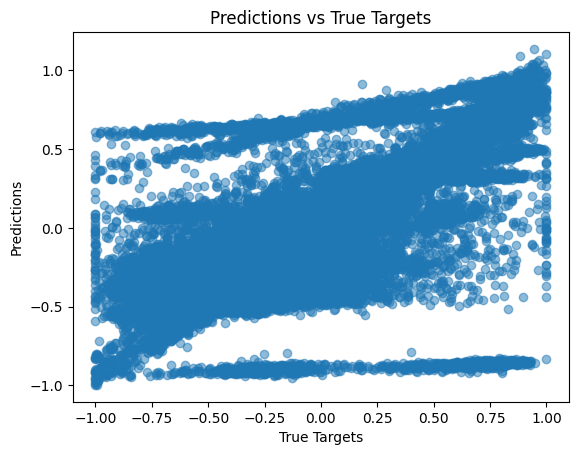

In [11]:
# Access predictions and targets
predictions = model_heat.test_predictions.cpu().numpy()
targets = model_heat.test_targets.cpu().numpy()

#compute RMSE manually
rmse = np.sqrt(np.mean((predictions - targets) ** 2))
print(f"RMSE: {rmse}")

#plot predictions vs targets
import matplotlib.pyplot as plt
plt.scatter(targets, predictions, alpha=0.5)
plt.xlabel("True Targets")
plt.ylabel("Predictions")
plt.title("Predictions vs True Targets")
plt.show()

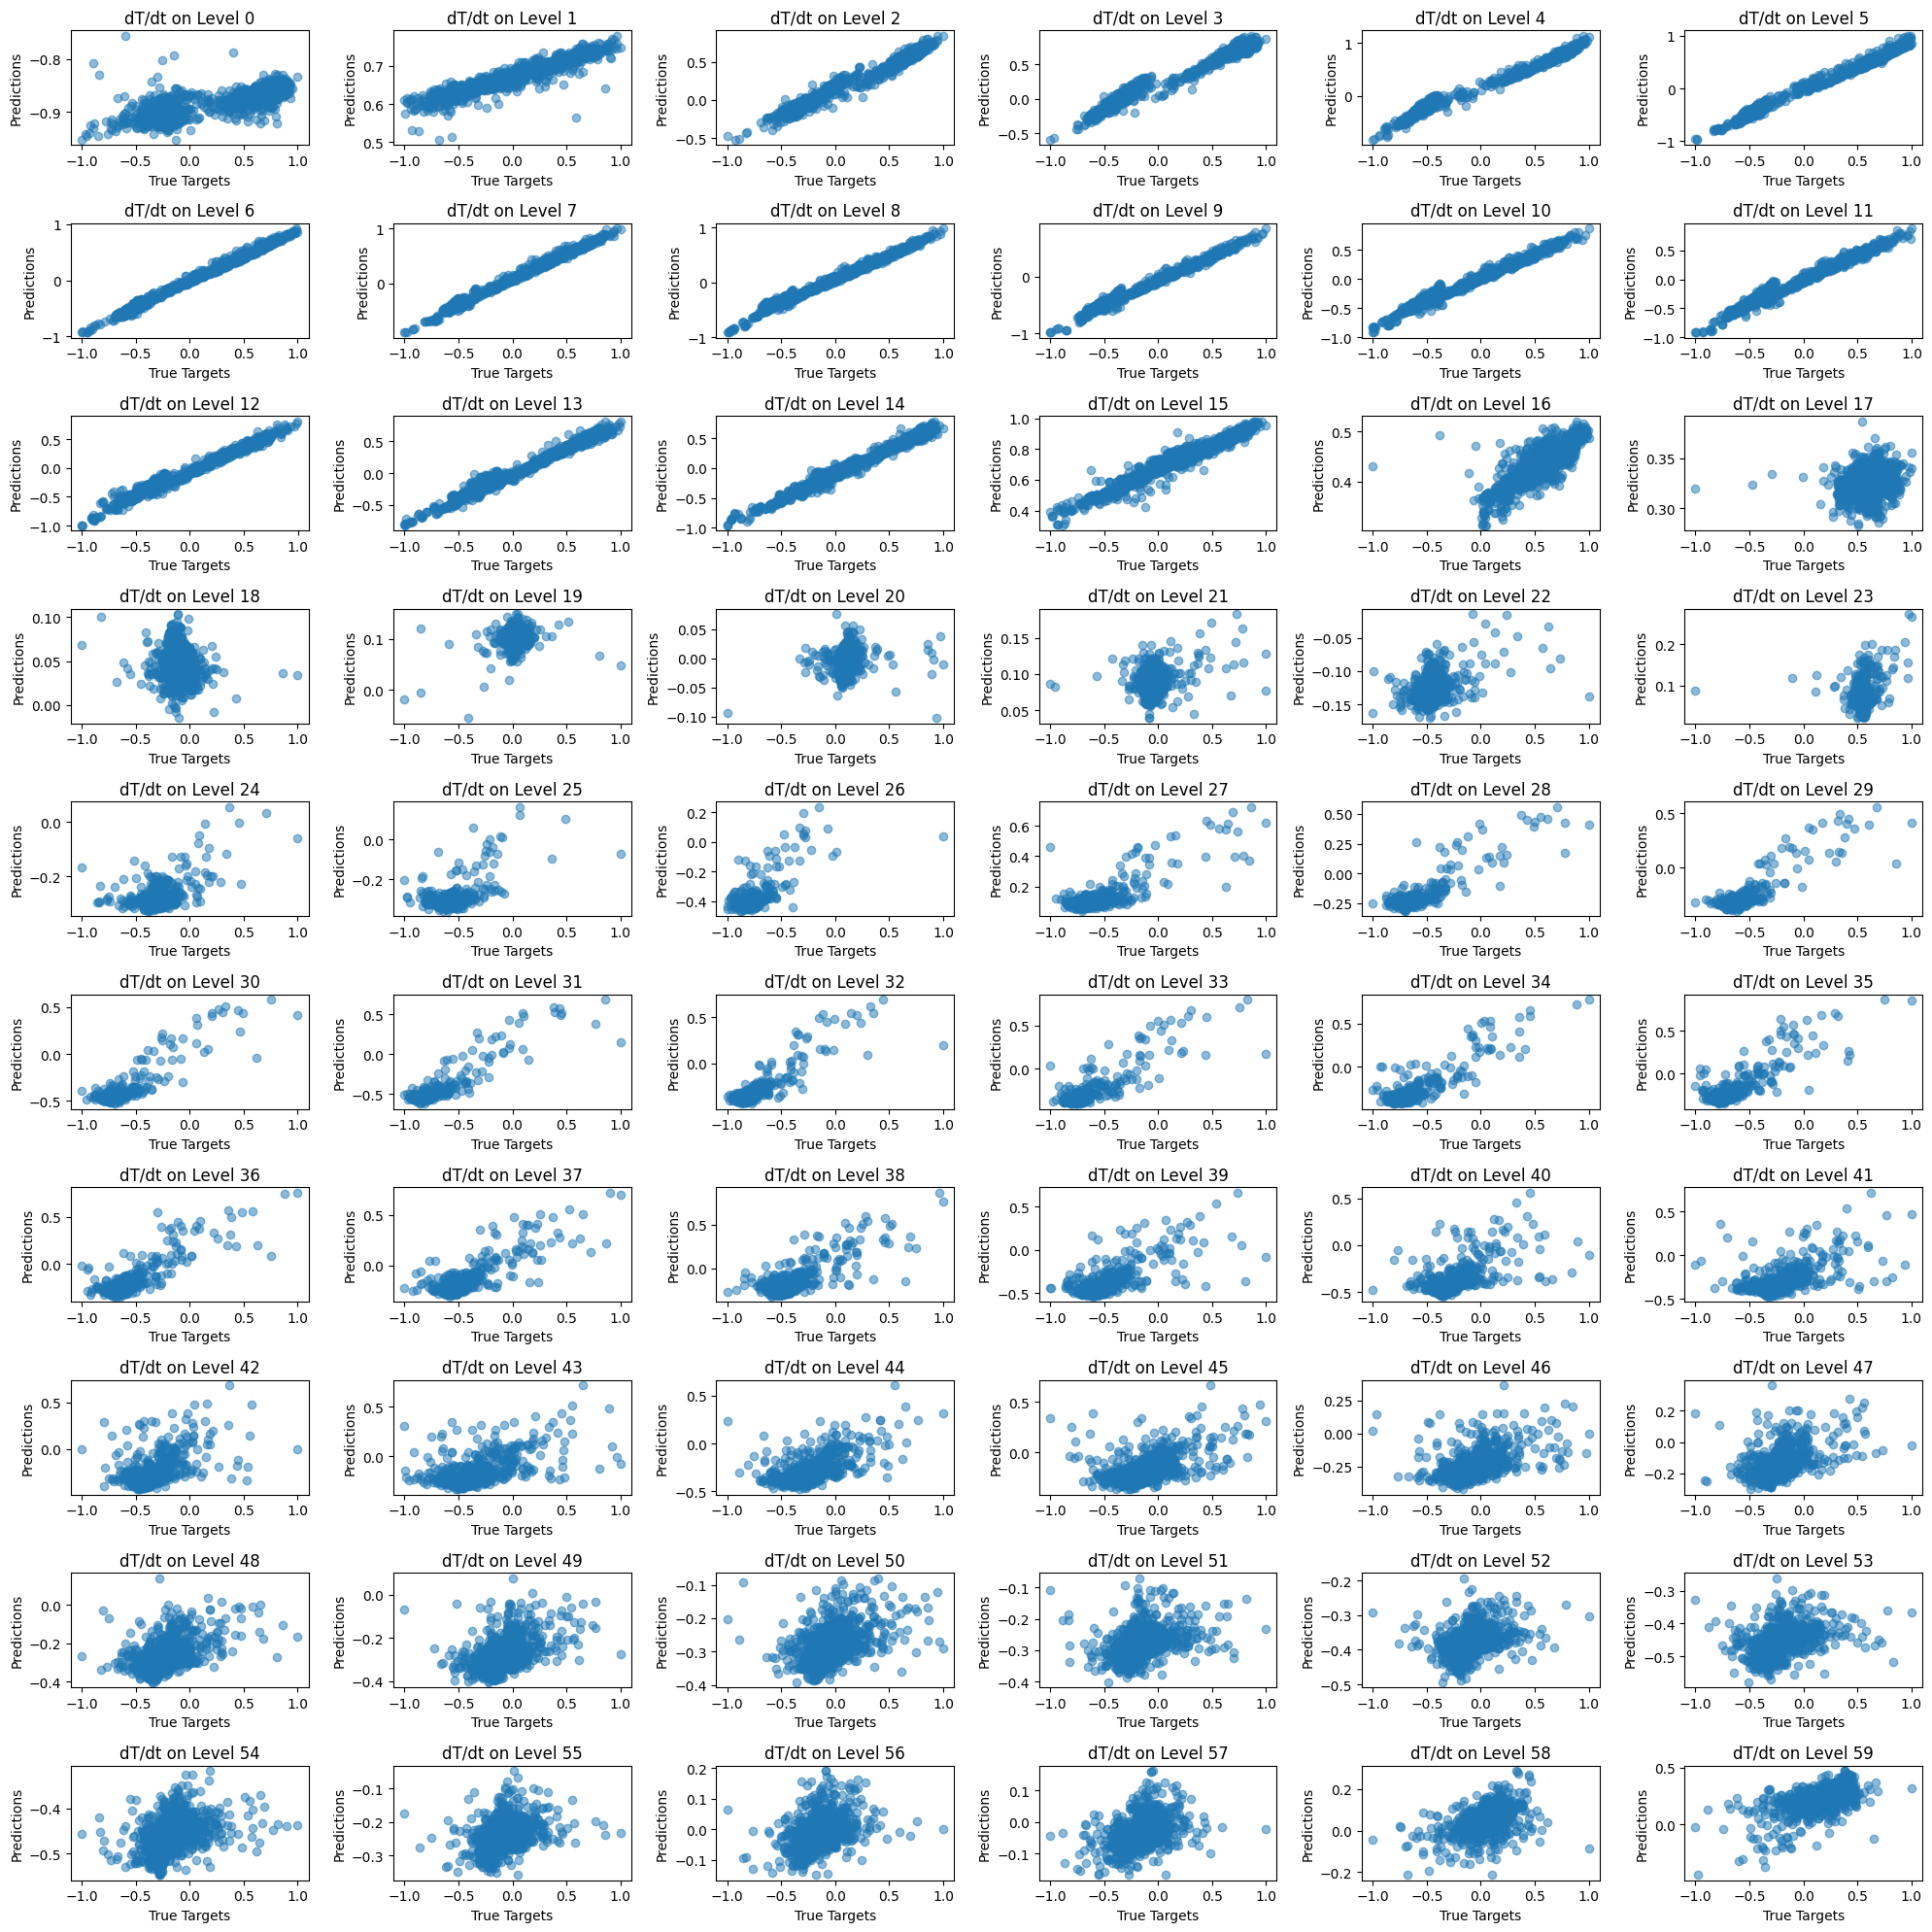

In [15]:
# Number of subplots
n_subplots = targets.shape[1]

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(20, 20))  # Adjust rows/columns for 60 subplots

# Flatten the axes array to iterate easily
axes = axes.flatten()

for i in range(n_subplots):
    axes[i].scatter(targets[:, i], predictions[:, i], alpha=0.5)
    axes[i].set_xlabel("True Targets")
    axes[i].set_ylabel("Predictions")
    axes[i].set_title(f"dT/dt on Level {i}")

# Hide any unused subplots (in case total subplots aren't divisible by rows/columns)
for j in range(n_subplots, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [18]:
# computing R2 score:
score = r2_score(targets, predictions)
print("total score: "+str(score))
for i in range(48):
  score = r2_score(targets[:,i], predictions[:,i])
  print(score)

total score: -1.9970523118972778
-4.2911057472229
-1.9061810970306396
0.8322950005531311
0.7540026903152466
0.8804611563682556
0.981299638748169
0.9871582984924316
0.9420435428619385
0.9226101636886597
0.9602922797203064
0.9176346659660339
0.9553988575935364
0.9495310187339783
0.9414597749710083
0.8986486196517944
-1.075824499130249
0.08464348316192627
-3.114499568939209
-1.7441742420196533
-0.9256018400192261
-1.0220937728881836
-1.2018940448760986
-5.379027366638184
-35.731754302978516
0.1773141622543335
-4.325015068054199
-11.616265296936035
-11.881404876708984
-4.721303462982178
-2.716165065765381
-1.2972064018249512
-1.4994370937347412
-7.332873344421387
-4.251979827880859
-3.1546292304992676
-6.684233665466309
-3.577561378479004
-1.8917996883392334
-1.0095019340515137
0.26820284128189087
-0.25048959255218506
0.02768772840499878
-0.14640271663665771
-0.2787790298461914
0.25672805309295654
0.21191436052322388
-0.5696969032287598
0.021049976348876953


### Clouds:
- moistening tendency
- change in liquid cloud mixing ratio
- change in ice cloud mixing ratio  
(not shown here, testing done in another notebook. Results: "working" notebook)


### Wind:
- zonal acceleration
- meridional acceleration  
(not shown here, testing done in another notebook. Results:"working" notebook)

## Radiation:
- shortwave radiation
- longwave radiation  
(not shown here, testing done in another notebook. Results: "working" notebook)

### Precipitation:
- rain rate
- snow rate  
(not shown here, testing done in another notebook. Results: "working" notebook)